# DataCite Example Queries

The following examples explore how to use the openly available BigQuery dataset available at: `ds-external-data.datacite.records_2025`

Further documentation on the DataCite schema, along with how to get connected to BigQuery can be found at:

https://support.datacite.org/docs/api


In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

In [ ]:
from google.cloud import bigquery

from google.cloud.bigquery import magics

project_id = input("Enter the name of a GBQ project to use when running the code in this notebook: ")

magics.context.project = project_id

bq_params = {}

client = bigquery.Client(project=project_id)

%load_ext bigquery_magics

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

**Before we go further, a quick warning. In BigQuery don't use "SELECT *" to explore a dataset. It will be expensive. Use only the columns that you need.**

# Exploring the DataCite dataset on Google BigQuery

In this notebook, we breakdown the DataCite schema in BigQuery, and demonstrate how to query each section.

* [Counting Records](#counting_records)

* [Attributes](#attributes)
  * [Resource Types](#attributes.types)
  * [Publication Years](#attributes.publicationYear)
  * [Titles and Publishers](#attributes.titles)
  * [Descriptions (Abstracts)](#attributes.descriptions)
  * [Subjects (Keywords)](#attributes.subjects)
  * [GeoLocations](#attributes.geoLocations)
  * [Rights & Licenses](#attributes.rightsList)
  * [Usage Counts](#attributes.usage)

* [People & Organizations](#people_orgs)
  * [Creators & Affiliations (ROR)](#creators)
  * [PID Adoption (ORCID)](#pids)

* [Connections & Funding](#connections)
  * [Related Identifiers (The PID Graph)](#attributes.relatedIdentifiers)
  * [Funding References](#attributes.fundingReferences)

* [Advanced: Deduplication](#deduplication)
  * [Handling Versions](#versions)

## <a name="counting_records"> Counting Records</a>

How many active DataCite DOIs do we have in this snapshot?

In [ ]:
%%bigquery df_overview
SELECT
  COUNT(*) as total_records
FROM
  `ds-external-data.datacite.records_2025`

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
print(f"Total DataCite Records: {df_overview['total_records'][0]:,}")

Total DataCite Records: 108,468,903


## <a name="attributes">Attributes</a>

### <a name="attributes.types">attributes.types</a>
What are the most common resource types?

In [ ]:
%%bigquery df_types
SELECT
  attributes.types.resourceTypeGeneral as type,
  COUNT(*) as count
FROM
  `ds-external-data.datacite.records_2025`
GROUP BY
  1
ORDER BY
  2 DESC
LIMIT 20

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df_types

,type,count
0,Dataset,56620402
1,Text,15878621
2,PhysicalObject,15428075
3,Image,8746688
4,JournalArticle,2450042
5,Other,1843033
6,Preprint,1741052
7,Collection,1154128
8,None,1022883
9,Software,777199


We can also look at the specific `resourceType` (free text) vs the controlled `resourceTypeGeneral`.

In [ ]:
%%bigquery df_types_detailed
SELECT
  attributes.types.resourceTypeGeneral as general_type,
  COALESCE(attributes.types.resourceType, '(Not Specified)') as specific_type,
  COUNT(*) as count
FROM
  `ds-external-data.datacite.records_2025`
GROUP BY
  1, 2
ORDER BY
  count DESC
LIMIT 15

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df_types_detailed

,general_type,specific_type,count
0,Dataset,Collection data,29198792
1,Dataset,(Not Specified),13968478
2,PhysicalObject,(Not Specified),7405021
3,Dataset,Digital Specimen,5027857
4,Dataset,Dataset,4344595
5,PhysicalObject,Individual Sample,2938016
6,Text,(Not Specified),2707204
7,Image,Media Object,2333670
8,JournalArticle,(Not Specified),2164782
9,Text,Article,2067047


### <a name="attributes.publicationYear">attributes.publicationYear</a>
How has the volume of research outputs grown over time?

In [ ]:
%%bigquery df_years
SELECT
  attributes.publicationYear as year,
  COUNT(*) as count
FROM
  `ds-external-data.datacite.records_2025`
WHERE
  attributes.publicationYear BETWEEN 2010 AND 2025
GROUP BY
  1
ORDER BY
  1 DESC

Query is running:   0%|          |

Downloading:   0%|          |

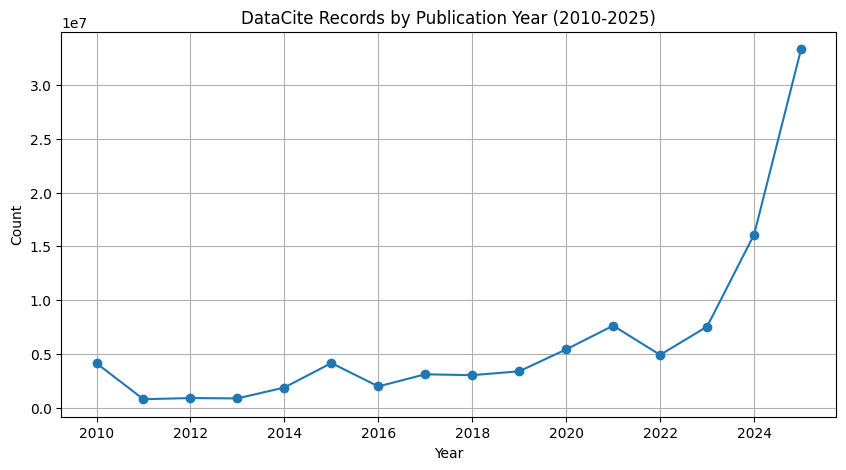

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(df_years['year'], df_years['count'], marker='o')
plt.title('DataCite Records by Publication Year (2010-2025)')
plt.xlabel('Year')
plt.ylabel('Count')
plt.grid(True)
plt.show()

### <a name="attributes.titles">attributes.titles & attributes.publisher</a>
What is the basic descriptive metadata for these records?

In [ ]:
%%bigquery df_core_detailed
SELECT
  id as doi,
  attributes.titles[SAFE_OFFSET(0)].title as primary_title,
  attributes.publisher.name as publisher,
  attributes.publicationYear
FROM
  `ds-external-data.datacite.records_2025`
LIMIT 5

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df_core_detailed

,doi,primary_title,publisher,publicationYear
0,10.13145/bacdive10460.20170425.1,Iodobacter fluviatilis (Moss et al. 1981) Loga...,DSMZ,2017
1,10.13145/bacdive10568.20170425.1,Gordonia sputi (Tsukamura 1978) Stackebrandt e...,DSMZ,2017
2,10.13145/bacdive10580.20170425.1,Gordonia hirsuta Klatte et al. 1996,DSMZ,2017
3,10.13145/bacdive10599.20170425.1,Gordonia polyisoprenivorans Linos et al. 1999,DSMZ,2017
4,10.13145/bacdive10663.20170425.1,Nocardia farcinica Trevisan 1889,DSMZ,2017


### <a name="attributes.descriptions">attributes.descriptions</a>
What are these records about? (Extracting abstracts)

In [ ]:
%%bigquery df_descriptions
SELECT
  id as doi,
  description_entry.descriptionType,
  COALESCE(SUBSTR(description_entry.description, 0, 200), '(No Description Available)') as abstract_snippet
FROM
  `ds-external-data.datacite.records_2025`,
  UNNEST(attributes.descriptions) as description_entry
WHERE
  description_entry.descriptionType = 'Abstract'
ORDER BY
  LENGTH(description_entry.description) DESC
LIMIT 5

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df_descriptions

,doi,descriptionType,abstract_snippet
0,10.15468/dl.rju5ws,Abstract,A dataset containing 0 species occurrences ava...
1,10.15468/dl.yzn2t7,Abstract,A dataset containing 0 species occurrences ava...
2,10.15468/dl.akzyxr,Abstract,A dataset containing 0 species occurrences ava...
3,10.15468/dl.x8cb7b,Abstract,A dataset containing 0 species occurrences ava...
4,10.15468/dl.8sh2f2,Abstract,A dataset containing 7968453 species occurrenc...


### <a name="attributes.subjects">attributes.subjects</a>
What are the most frequent keywords used in the dataset?

In [ ]:
%%bigquery df_subjects_list
SELECT
  subj.subject as keyword,
  COUNT(*) as frequency
FROM
  `ds-external-data.datacite.records_2025`,
  UNNEST(attributes.subjects) as subj
GROUP BY
  1
ORDER BY
  2 DESC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df_subjects_list

,keyword,frequency
0,sh85103065 Plasma Diagnostics,30000000
1,14020 Nuclear Fusion,30000000
2,14010 Plasma Science,30000000
3,sh85092995 Nuclear Fusion,30000000
4,FOS: Biological sciences,7967745
5,Life,4958411
6,biodiversity,4046150
7,GBIF,3998517
8,species occurrences,3998242
9,Biodiversity,3644131


### <a name="attributes.geoLocations">attributes.geoLocations</a>
Where was data collected?

In [ ]:
%%bigquery df_geoloc
SELECT
  id as doi,
  geo.geoLocationPlace,
  geo.geoLocationPoint.pointLatitude as lat,
  geo.geoLocationPoint.pointLongitude as long
FROM
  `ds-external-data.datacite.records_2025`,
  UNNEST(attributes.geoLocations) as geo
WHERE
  geo.geoLocationPlace IS NOT NULL
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df_geoloc

,doi,geoLocationPlace,lat,long
0,10.20375/0000-000b-d4f0-6,Preussen; Posen,NaN,NaN
1,10.20375/0000-000e-8b85-f,España,NaN,NaN
2,10.20375/0000-000e-8b85-f,Spanien,NaN,NaN
3,10.20375/0000-000e-8b85-f,Spain,NaN,NaN
4,10.20375/0000-000e-8b86-e,Spanien,NaN,NaN
5,10.20375/0000-000e-8b86-e,España,NaN,NaN
6,10.20375/0000-000e-8b86-e,Spain,NaN,NaN
7,10.20375/0000-000e-8b87-d,España,NaN,NaN
8,10.20375/0000-000e-8b87-d,Spain,NaN,NaN
9,10.20375/0000-000e-8b87-d,Spanien,NaN,NaN


### <a name="attributes.rightsList">attributes.rightsList</a>
What are the most common licenses?

In [ ]:
%%bigquery df_licenses
SELECT
  r.rights as license_name,
  r.rightsUri as license_url,
  COUNT(*) as count
FROM
  `ds-external-data.datacite.records_2025`,
  UNNEST(attributes.rightsList) as r
GROUP BY
  1, 2
ORDER BY
  3 DESC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df_licenses

,license_name,license_url,count
0,LHD Data Usage and Publication Agreement,https://www-lhd.nifs.ac.jp/pub/pdf/DataUsageAg...,30000000
1,Rights and Terms of Use for Data,https://www-lhd.nifs.ac.jp/pub/RightsTerms.html,30000000
2,Creative Commons Attribution 4.0 International,https://creativecommons.org/licenses/by/4.0/le...,12135728
3,Creative Commons Zero v1.0 Universal,https://creativecommons.org/publicdomain/zero/...,10129173
4,Creative Commons Attribution Non Commercial 4....,https://creativecommons.org/licenses/by-nc/4.0...,4180167
5,Open Access,info:eu-repo/semantics/openAccess,3559776
6,Attribution-NonCommercial (CC BY-NC),https://creativecommons.org/licenses/by-nc/4.0/,3159267
7,"arXiv.org perpetual, non-exclusive license",http://arxiv.org/licenses/nonexclusive-distrib...,1803084
8,None,info:eu-repo/semantics/openAccess,1083431
9,Creative Commons Attribution Share Alike 4.0 I...,https://creativecommons.org/licenses/by-sa/4.0...,969654


### <a name="attributes.usage">attributes.citationCount & attributes.viewCount</a>
Which records have citations or views recorded in the record?

In [ ]:
%%bigquery df_usage
SELECT
  id as doi,
  attributes.titles[SAFE_OFFSET(0)].title as title,
  attributes.citationCount,
  attributes.viewCount,
  attributes.downloadCount
FROM
  `ds-external-data.datacite.records_2025`
WHERE
  attributes.citationCount > 0
ORDER BY
  attributes.citationCount DESC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df_usage

,doi,title,citationCount,viewCount,downloadCount
0,10.15468/ab3s5x,iNaturalist Research-grade Observations,30805,0,0
1,10.5519/0002965,Collection specimens,21487,0,0
2,10.15468/inygc6,International Barcode of Life project (iBOL),18751,0,0
3,10.15468/uc1apo,NABU|naturgucker,17388,0,0
4,10.15468/ib5ypt,Naturalis Biodiversity Center (NL) - Botany,16789,0,0
5,10.15468/hja69f,Tropicos MO Specimen Data,16759,0,0
6,10.15468/6e8nje,The New York Botanical Garden Herbarium (NY),15139,0,0
7,10.15468/p5rupv,"Museum of Comparative Zoology, Harvard University",13869,0,0
8,10.15468/yo3mmu,Phanerogamic Botanical Collections (S),10196,0,0
9,10.5281/zenodo.10680266,Checklist 2017 der Gefässpflanzenflora der Sch...,9576,0,0


## <a name="people_orgs">People & Organizations</a>

### <a name="creators">Creators & Affiliations (ROR)</a>
Who created this work, and what organizations are they affiliated with?

In [ ]:
%%bigquery df_creators_detailed
SELECT
  id as doi,
  creator.name as creator_name,
  (SELECT nameIdentifier FROM UNNEST(creator.nameIdentifiers) WHERE nameIdentifierScheme = 'ORCID' LIMIT 1) as orcid,
  ARRAY_TO_STRING(ARRAY(SELECT name FROM UNNEST(creator.affiliation)), '; ') as affiliations
FROM
  `ds-external-data.datacite.records_2025`,
  UNNEST(attributes.creators) as creator
WHERE
  ARRAY_LENGTH(creator.affiliation) > 0
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df_creators_detailed

,doi,creator_name,orcid,affiliations
0,10.58041/aprender.158,"Bonifácio, Evangelina",None,"VALORIZA Instituto Politécnico de Portalegre, ..."
1,10.58041/aprender.160,"Russo, Ana Rita",None,Mestre em Educação e Proteção de Crianças e Jo...
2,10.58041/aprender.161,"De Jesus, Ana Salomé",None,"Doutoranda, Universidad de Salamanca"
3,10.58041/aprender.165,"Bravo Nico, José",None,Universidade de Évora
4,10.58041/aprender.165,"Nico, Lurdes Pratas",None,Universidade de Évora/Escola de Ciências Socia...
5,10.58041/aprender.168,"Balola, Tânia",None,Santa Casa da Misericórdia de Gavião. Escola S...
6,10.58041/aprender.169,"Ribeiro, Maria",None,Escola Superior de Educação do Instituto Polit...
7,10.58041/aprender.169,"Castro, Marilia",None,Escola Superior de Educação | Instituto Polité...
8,10.58041/aprender.170,"Madureira, Cristiana",None,ESECS Instituto Politécnico de Leiria
9,10.58041/aprender.176,"Fernandes, Pedro",None,Faculdade de Letras - Universidade de Coimbra


We can also find works by a specific organization (e.g., CERN) by joining with the **ROR** table.

In [ ]:
%%bigquery df_org
SELECT


  affiliation.affiliationIdentifier, affiliation.name,

  count(distinct dc.id) dois,
FROM
  `ds-external-data.datacite.records_2025` dc
INNER JOIN
  UNNEST(dc.attributes.creators) as creator
INNER JOIN
  UNNEST(creator.affiliation) as affiliation
WHERE
  affiliation.affiliationIdentifierScheme = 'ROR'
  AND dc.attributes.publicationYear = 2024
GROUP BY 1,2
ORDER BY 3 DESC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
display(df_org)

,affiliationIdentifier,name,dois
0,https://ror.org/01t3wyv61,National Institute for Fusion Science,9529595
1,https://ror.org/01t3wyv61,National Institute for Fusion Science (NIFS),470546
2,https://ror.org/02skbsp27,Leibniz Institute of Plant Genetics and Crop P...,51517
3,https://ror.org/031rekg67,Swinburne University of Technology,23468
4,https://ror.org/03p74gp79,University of Cape Town,23062
5,https://ror.org/02tyer376,Leibniz Institute DSMZ - German Collection of ...,16185
6,https://ror.org/04ttjf776,RMIT University,8091
7,https://ror.org/052gg0110,University of Oxford,6182
8,https://ror.org/03wd9za21,None,6109
9,https://ror.org/0130frc33,University of North Carolina at Chapel Hill,5815


### <a name="pids">PID Adoption (ORCID & ROR)</a>

How many records include an ORCID iD for creators or contributors?

In [ ]:
%%bigquery df_orcid_by_type


SELECT
  attributes.types.resourceTypeGeneral as resource_type,
  COUNT(distinct id) allrecords,
  COUNT(distinct CASE WHEN ni.nameIdentifierScheme  = 'ORCID' THEN  id END) as creator_orcid_count,
  COUNT(distinct CASE WHEN nit.nameIdentifierScheme = 'ORCID' THEN  id END) as contributor_orcid_count
FROM
  `ds-external-data.datacite.records_2025`
  LEFT JOIN UNNEST(attributes.creators) c
    LEFT JOIN UNNEST(c.nameIdentifiers) ni
  LEFT JOIN UNNEST(attributes.contributors) ct
    LEFT JOIN UNNEST(ct.nameIdentifiers) nit
 #WHERE  'ORCID' in (ni.nameIdentifierScheme,nit.nameIdentifierScheme)

GROUP BY
  1
ORDER BY
  2 DESC

In [ ]:
df_orcid_by_type

,resource_type,allrecords,creator_orcid_count,contributor_orcid_count
0,Dataset,56620402,31770017,29358360
1,Text,15878621,1884743,93026
2,PhysicalObject,15428075,1499541,4321
3,Image,8746688,1332448,817162
4,JournalArticle,2450042,314967,19053
5,Other,1843033,101012,10825
6,Preprint,1741052,93058,4103
7,Collection,1154128,332515,160524
8,None,1022883,3312,2143
9,Software,777199,204824,11220


In [3]:
%%bigquery df_orcid_by_type_year
SELECT
  attributes.publicationYear as year,
  COUNT(distinct id) allrecords,
  COUNT(distinct CASE WHEN ni.nameIdentifierScheme =  'ORCID' THEN  id END) as creator_orcid_count,
  COUNT(distinct CASE WHEN nit.nameIdentifierScheme = 'ORCID' THEN  id END) as contributor_orcid_count,
  ROUND(100*COUNT(distinct CASE WHEN 'ORCID' in (nit.nameIdentifierScheme,ni.nameIdentifierScheme) THEN  id END)/ COUNT(distinct id) ,2) percentage_with_orcid
FROM
  `ds-external-data.datacite.records_2025`
  LEFT JOIN UNNEST(attributes.creators) c
    LEFT JOIN UNNEST(c.nameIdentifiers) ni
  LEFT JOIN UNNEST(attributes.contributors) ct
    LEFT JOIN UNNEST(ct.nameIdentifiers) nit
 WHERE  attributes.types.resourceTypeGeneral = 'Dataset'
 and attributes.publicationYear between 2015 and 2025
GROUP BY
  1
ORDER BY
  1 ASC

UsageError: Cell magic `%%bigquery` not found.


In [ ]:
df_orcid_by_type_year.plot(x='year', y='percentage_with_orcid', kind='bar')

How many records contain at least one ROR ID in the affiliation metadata?

In [ ]:
%%bigquery df_ror_count
SELECT
  COUNT(DISTINCT id) as records_with_ror_affiliation,
  COUNTIF(EXISTS(
    SELECT 1 FROM UNNEST(attributes.creators) c, UNNEST(c.affiliation) a
    WHERE a.affiliationIdentifierScheme = 'ROR'
  )) as records_with_creator_ror,
  COUNTIF(EXISTS(
    SELECT 1 FROM UNNEST(attributes.contributors) c, UNNEST(c.affiliation) a
    WHERE a.affiliationIdentifierScheme = 'ROR'
  )) as records_with_contributor_ror
FROM
  `ds-external-data.datacite.records_2025`

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
display(df_ror_count)

,records_with_ror_affiliation,records_with_creator_ror,records_with_contributor_ror
0,108468903,33271175,30904477


## <a name="connections">Connections & Funding</a>

### <a name="attributes.relatedIdentifiers">attributes.relatedIdentifiers (The PID Graph)</a>
What other research objects (papers, software, versions) is this record connected to?

In [ ]:
%%bigquery df_pid_graph
SELECT
  id as source_doi,
  rel.relationType,
  rel.relatedIdentifierType as target_type,
  rel.relatedIdentifier as target_id
FROM
  `ds-external-data.datacite.records_2025`,
  UNNEST(attributes.relatedIdentifiers) as rel
WHERE
  rel.relationType IN ('IsSupplementTo', 'Cites', 'IsVersionOf')
LIMIT 10

In [ ]:
display(df_pid_graph)

Which relationship types are most common?

In [ ]:
%%bigquery df_relations
SELECT
  relation.relationType,
  COUNT(*) as frequency
FROM
  `ds-external-data.datacite.records_2025`,
  UNNEST(attributes.relatedIdentifiers) as relation
GROUP BY
  1
ORDER BY
  2 DESC
LIMIT 15

In [ ]:
display(df_relations)

### <a name="attributes.fundingReferences">attributes.fundingReferences</a>
Who paid for this research?

In [ ]:
%%bigquery df_funding_refs
SELECT
  id as doi,
  funding.funderName,
  funding.awardNumber,
  funding.awardTitle
FROM
  `ds-external-data.datacite.records_2025`,
  UNNEST(attributes.fundingReferences) as funding
ORDER BY
  funding.funderName DESC
LIMIT 10

In [ ]:
display(df_funding_refs)

## <a name="deduplication">Advanced: Deduplication</a>

### <a name="versions">Handling Versions</a>

When analyzing research outputs, you often want to avoid double-counting. For example, a dataset might have versions 1.0, 1.1, and 2.0, all with different DOIs.

The following query uses a rigorous filtering strategy to remove superseded versions (`IsPreviousVersionOf`) and redundant identical copies (`IsIdenticalTo`), keeping only the most relevant record.

In [ ]:
%%bigquery df_deduplicated
WITH dois_to_remove AS (
    SELECT
        dc.id
    FROM
        `ds-external-data.datacite.records_2025` dc
    INNER JOIN
        UNNEST(dc.attributes.relatedIdentifiers) related
        ON related.relationType IN ('IsIdenticalTo', 'IsPreviousVersionOf')
    -- Join with the table again to get the related DOI's metadata (date)
    INNER JOIN
        `ds-external-data.datacite.records_2025` dc2
        ON dc2.id = related.relatedIdentifier
    WHERE
        (
            -- Logic for Identical items: Remove the one registered LATER (or higher ID if tie)
            (related.relationType = 'IsIdenticalTo'
            AND (
                SAFE_CAST(dc.attributes.registered AS TIMESTAMP) > SAFE_CAST(dc2.attributes.registered AS TIMESTAMP)
                OR (
                    SAFE_CAST(dc.attributes.registered AS TIMESTAMP) = SAFE_CAST(dc2.attributes.registered AS TIMESTAMP)
                    AND dc.id > dc2.id
                )
            ))
            -- Logic for Versions: If dc is a "Previous Version Of" something else, remove dc.
            OR (related.relationType = 'IsPreviousVersionOf')
        )
    -- Optional: Ensure we only deduplicate items owned by the same client/repository
    AND dc2.relationships.client.data.id = dc.relationships.client.data.id
)

SELECT
    COUNT(dc.id) as unique_records
FROM
    `ds-external-data.datacite.records_2025` dc
LEFT JOIN
    dois_to_remove dcr
    ON dcr.id = dc.id
WHERE
    dcr.id IS NULL

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
print(f"Total Deduped Records: {df_deduplicated['unique_records'][0]:,}")

Total Deduped Records: 105,059,663
